In [2]:
#---This program is used to forecast 1 week CDRs based on 55 previous days' data

#---Install these bibs so the program works properly
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model
from numpy import loadtxt
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

2024-09-19 15:39:55.827154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#--Loading Cell_ID vector, whose elements tell from which ID the matrix_TS row is the corresponding time-series

Cell_ID = loadtxt('ID_labels.csv', delimiter=',') 
df = pd.read_csv('matrixTS.csv',header=None)
df.head(6)

,0,1,2,3,4,5,6,7,8,9,...,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487
0,13,11,8,7,8,9,11,12,13,18,...,23.0,17.0,20.0,16.0,16.0,18.0,19.0,21.0,17.0,13.0
1,13,11,10,7,6,9,11,11,13,17,...,22.0,15.0,20.0,15.0,15.0,18.0,20.0,19.0,17.0,13.0
2,15,11,9,11,9,8,12,18,23,31,...,6.0,9.0,9.0,11.0,8.0,7.0,7.0,8.0,7.0,5.0
3,12,11,7,9,6,6,8,15,12,23,...,14.0,12.0,17.0,17.0,15.0,14.0,12.0,13.0,14.0,10.0
4,10,8,11,7,8,8,12,16,16,16,...,28.0,26.0,23.0,26.0,27.0,19.0,18.0,20.0,14.0,18.0
5,11,8,7,6,8,8,6,7,12,14,...,14.0,13.0,12.0,14.0,14.0,12.0,12.0,16.0,11.0,10.0


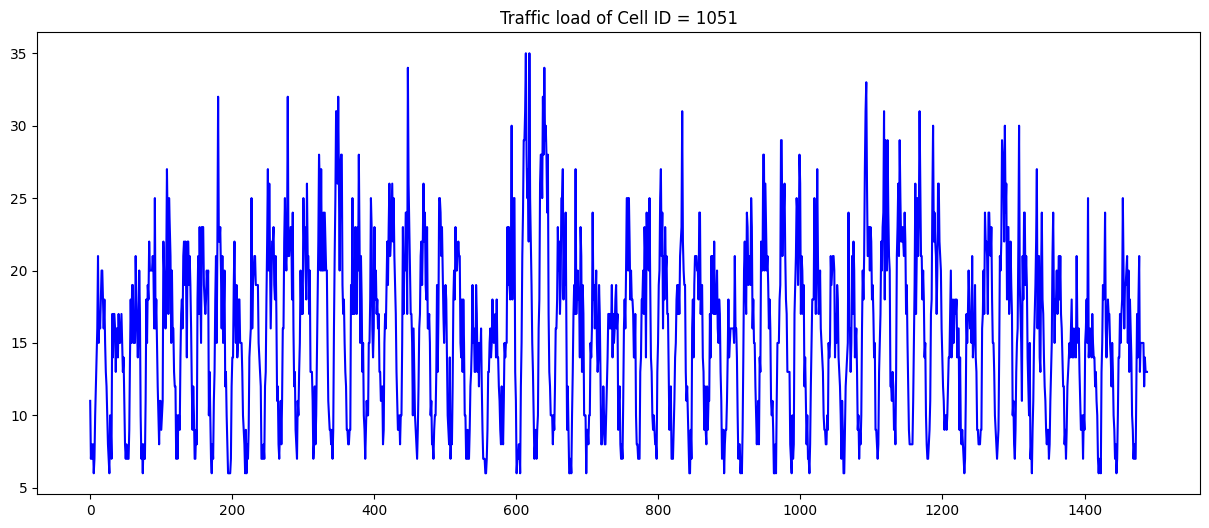

In [4]:
#--Defines the Cell ID to be forecasted and plots the corresponding time-series

days = 62 #Train and validation size need to be changed if this value is tunned
matrix = df.to_numpy()

ID=60
time_series = matrix[ID][:]
hour = np.linspace(0,24*days,24*days)

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell ID = %d' % (Cell_ID[60])) 
plt.plot(hour,time_series,'b')

In [5]:
#---This function creates the sliding window to construct the training data set

def df_to_X_y(df,window_size):
    df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]] 
        X.append(row)
        y.append(df_as_np[i+window_size])
    return np.array(X), np.array(y)

#-Each vector of matrix X contains "window_size" elements used as input to train the model
#-Each element of vector y contains one element that the model needs to predict based on the respective row of X

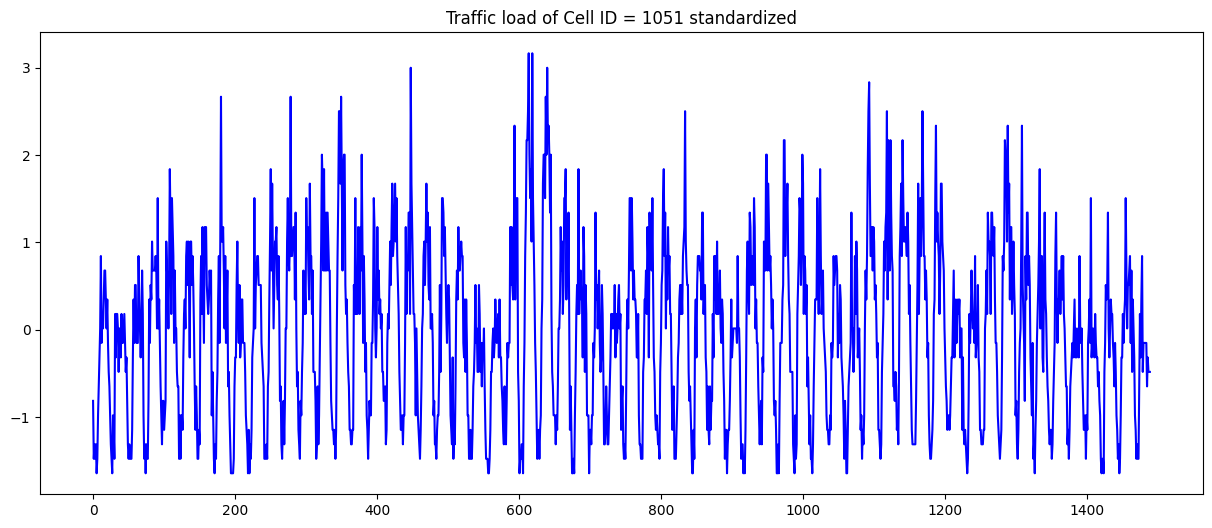

In [6]:
#---Standardization of the CDR time-series

train_size = 24*50 # defines number of samples of training data: 50 days with 24 samples each
validation_size = 24*5 # defines number of samples of validation data: 5 days with 24 samples each

time_series_mean = time_series[:train_size].mean() #--Considering just the training part
time_series_std = time_series[:train_size].std() #--Considering just the training part

time_series_standardized = (time_series - time_series_mean) / time_series_std

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell ID = %d standardized' % (Cell_ID[60])) 
plt.plot(hour,time_series_standardized,'b')

In [7]:
WINDOW_SIZE = 24
X,y = df_to_X_y(time_series_standardized,WINDOW_SIZE)
X.shape, y.shape

((1464, 24, 1), (1464,))

## Splitting data to training and testing

In [8]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:(train_size+validation_size)], y[train_size:(train_size+validation_size)]
y_test = time_series[(train_size+validation_size):]

X_train.shape, X_val.shape

((1200, 24, 1), (120, 24, 1))

## Constructing Simple RNN model

In [9]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE,1)))

#-Comment or uncomment lines to insert/remove layers of the RNN
#-Change the number of neurons inside each layers

model1.add(SimpleRNN(64,return_sequences=True)) # default activation function is tanh
model1.add(SimpleRNN(64,return_sequences=True)) # default activation function is tanh
model1.add(SimpleRNN(64,return_sequences=True)) # default activation function is tanh
model1.add(SimpleRNN(64)) # default activation function is tanh

model1.add(Dense(32,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()


2024-09-19 15:40:03.283451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-19 15:40:03.370032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-19 15:40:03.370113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-19 15:40:03.376193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-19 15:40:03.376306: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 24, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 24, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 24, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,105 (121.50 KB)

 Trainable params: 31,105 (121.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#--Model Training

#-Set the hyperparemeters according to your application: learning_rate, epochs, batch size
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train,y_train, validation_data=(X_val,y_val),epochs=1000, batch_size=32)

Epoch 1/1000


I0000 00:00:1726760408.331810    4936 service.cc:145] XLA service 0xb984ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726760408.332012    4936 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-09-19 15:40:08.446517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-19 15:40:08.910679: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 6/38 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2487 - root_mean_squared_error: 1.1159

I0000 00:00:1726760410.381367    4936 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1726760410.384608    4936 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7592 - root_mean_squared_error: 0.8605

I0000 00:00:1726760413.095559    4935 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 24 bytes spill stores, 24 bytes spill loads



38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.7527 - root_mean_squared_error: 0.8567 - val_loss: 0.4173 - val_root_mean_squared_error: 0.6453
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2798 - root_mean_squared_error: 0.5287 - val_loss: 0.3835 - val_root_mean_squared_error: 0.6179
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2701 - root_mean_squared_error: 0.5196 - val_loss: 0.3651 - val_root_mean_squared_error: 0.6044
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855 - val_loss: 0.3736 - val_root_mean_squared_error: 0.6101
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2415 - root_mean_squared_error: 0.4913 - val_loss: 0.3720 - val_root_mean_squared_error: 0.6094
Epoch 6/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2337 - root_mean_squared_error: 0.4830 - val_loss: 0.3559 - val_root_mean_squared_error: 0.5976
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - lo

In [11]:
#---Predictions for "N_day_pred" days

predictions_standardized = []
vec_last_samples = X_val[len(y_val)-1]

vec_last_samples = vec_last_samples.reshape((vec_last_samples.shape[1], vec_last_samples.shape[0], 1))

N_day_pred = 7
for i in range(0,24*N_day_pred):
    prediction = model1.predict(vec_last_samples).flatten() #flatten() is just to take the []
    predictions_standardized.append(prediction)
    
    for j in range(0,WINDOW_SIZE-1):
        vec_last_samples[0,j,0] = vec_last_samples[0,j+1,0]
    vec_last_samples[0,int(WINDOW_SIZE-1),0] = prediction
    #print(vec_last_samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/tmp/ipykernel_520/1855435985.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_last_samples[0,int(WINDOW_SIZE-1),0] = prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

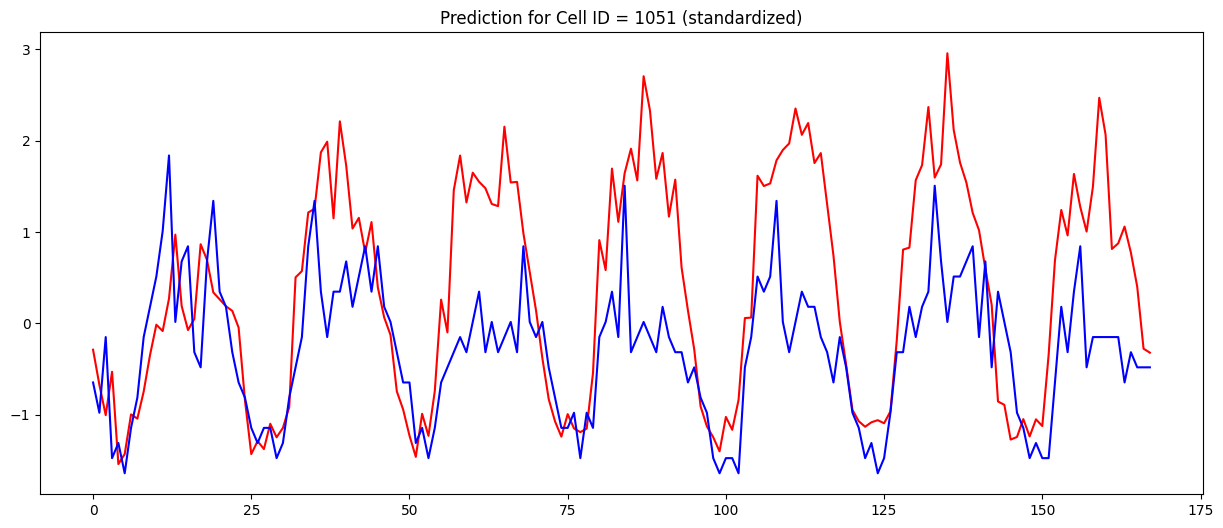

In [12]:
#---Plotting the predictions

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d (standardized)' % (Cell_ID[60])) 
plt.plot(predictions_standardized,'r')
plt.plot(time_series_standardized[train_size+validation_size:],'b')

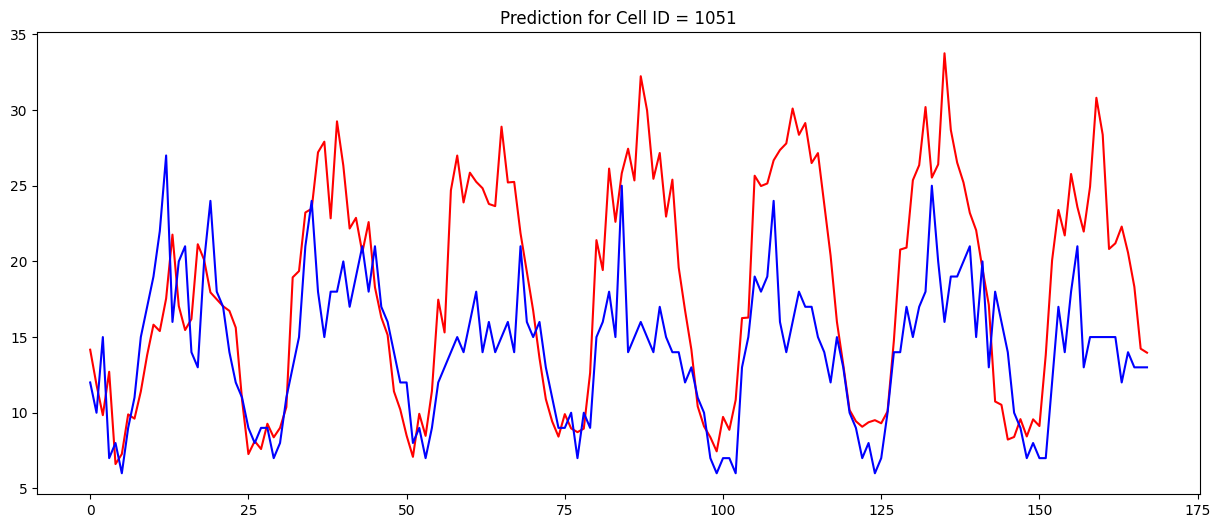

In [13]:
#--Ploting the actual result (not considering mean and std)
predictions_standardized = np.array(predictions_standardized)
predictions_week = predictions_standardized*time_series_std+time_series_mean

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d' % (Cell_ID[60])) 
plt.plot(predictions_week,'r')
plt.plot(y_test,'b')

In [14]:
MAE = mean_absolute_error(predictions_week,y_test)
MSE = mean_squared_error(predictions_week,y_test)
print('MAE:', "%.3f" % MAE)
print('MSE:', "%.3f" % MSE)

MAE: 5.132
MSE: 44.204
